# Product's price prediction by nutrition values

In this project, we wanted to find the connection between the nutrition values of products and their price. we want to emphasize that we were awarded to the fact that there are other causes to a certain products' price, such as tax, where the product was produced (if it has been imported), etcetera.

Thus, we worked on the project while knowing that there might not be a full connection between the nutrition values and the price of a product, but these are the aspects we chose to focus on in our project.

We started by doing web-scraping from the website of the grocery network 'Shufersal'. https://www.shufersal.co.il/online/he/A

The goal is to create a model that accepts the nutrition values of a product and predicts its estimated price.

## Table of Contents:
####  1. Getting to know the data, train test split, initial data cleanse
####  2. Creating a new data set
####  3. Analyzing and visualizing the first data set
####  4. Choosing a metric method and checking habits of dummy-model
####  5. Sampling models (and checking with cross validation):
     -A. Linear regression
     -B. Decision tree regressor 
     -C. Random forest regressor
####  6. comparing models scores and choosing the final model
####  7. conclusion

## 1. Getting to know the data, train test split, initial data cleanse:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as MSE

plt.style.use('seaborn')

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\Regression\data_converted_to_english.csv', index_col = False, low_memory=False)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9603 entries, 0 to 9602
Columns: 106 entries, Product_Name to Chlorophyll
dtypes: float64(81), int64(14), object(11)
memory usage: 7.8+ MB
None


C:\Users\shira\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8,9,53) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Product_Name,code,1_kg,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,...,chromium,Molybdenum,1_meter,100_meters,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,P_964560,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0
1,Gilded_apple,P_963136,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0
2,lemon,P_964492,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0
3,Orange_in_the_juice_network,P_964348,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0
4,Avocado,P_964980,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0


In [3]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)
prod = train_set.copy()

In [4]:
prod.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
prod= prod.set_index('code')
prod = prod.drop_duplicates() #we figured that if there are duplicates within the data, we should drop them
prod= prod.set_index('Product_Name')

In [5]:
#in order to turn all the objects we have to numeric - float or int
for col in prod.columns:  
    prod[col] = pd.to_numeric(prod[col], errors='coerce')
prod = prod.fillna(0)
sts_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index #we wanted to save all the columns we droped, so we could drop them in the test set as well
prod = prod.loc[:, (prod != 0).any(axis=0)]
prod.info() #in order to see that we scceeded and to have a look at the columns

<class 'pandas.core.frame.DataFrame'>
Index: 7268 entries, Stevia_sucrose_300_tablets to Chocolate_Granola_Crunch
Data columns (total 98 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1_kg                                 7268 non-null   float64
 1   Vitamin_B1                           7268 non-null   float64
 2   Vitamin_B6                           7268 non-null   float64
 3   Dietary_fiber                        7268 non-null   float64
 4   Folic_acid                           7268 non-null   float64
 5   energy                               7268 non-null   float64
 6   Proteins                             7268 non-null   float64
 7   Carbohydrates                        7268 non-null   float64
 8   Fats                                 7268 non-null   float64
 9   sodium                               7268 non-null   float64
 10  Vitamin_B3                           7268 non-null   flo

### After a brief look at the columns we have, we pointed out a couple of things that needed to be done:
##### Get rid of the unwanted units we have:
we want the get rid of all the products that are not measured by 100_g or 1_kg (and delete the rows of these units).
afterward, we need to unite the 100_g and 1_kg units (by dividing 1_kg by 10 we'll get the price for 100_g).
#### we'll check which columns are left, and with them:
##### Unite the columns:
- DHA_fatty_acid and DHA 
- A_vitamin and Vitamin_A_is_worth_retinol 
- Dietary_fiber and Dietary_fiber.1 
- Potassium and K_Potassium (two different names to the same thing)
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E. (When referring generally to vitamin E, it is therefore related to the alpha-tocopherol form https://www.wikirefua.org.il/w/index.php/%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_-_Vitamin_-_E )
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium, and Vitamin_b3 (they are referring to the same thing: https://en.wikipedia.org/wiki/Niacin)
- sodium and Chloride
- DHA and EPA with DHA_+_EPA (?)

##### Look at features we suspect may have a high correlation:
- Vitamin b's group
- all the things that contain sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat
- DHA and EPA with DHA_+_EPA (?)

In [6]:
#first, we'll find the products without the wanted price units 
unwanted_units = prod[(prod['100_g']==0) & (prod['1_kg']==0)].index
#moreover, we'll check if there are any products with more than one wanted price units 
print(prod[(prod['100_g']!=0) & (prod['1_kg']!=0)].index) #as excpected, there aren't products like these, a.k.a - the scraping did it's job well
#we want to remove the products without the wanted price units
prod = prod.drop(unwanted_units) #dropes products with unwanted units
all_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index #again, we wanted to save all the columns we droped, so we could drop them in the test set as well
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero, such as columns of units that are not 100_g or 1_kg 
prod['1_kg'] = prod['1_kg']/10 #transfering the units
prod['price_per_100g'] = prod['1_kg'] + prod['100_g']
prod = prod.drop(['100_g' ,'1_kg'], axis=1)

Index([], dtype='object', name='Product_Name')


In [7]:
#in order to reduce background noise, we decided to drop the columns in which there are less than 20 products with this feature
prod = prod.reset_index()
arr = np.array([])
col_droped = np.array([])
for col in prod.columns:
    if prod[col].astype(bool).sum(axis=0)<20: #all the features that less than a third precent of the products have
        arr = np.append(arr, prod[col].to_numpy().nonzero())
        col_droped = np.append(col_droped, col) #saved the columns we droped in order to drop from test set
arr = set(arr) #all number of rows without duplicates
for i in arr:
    prod = prod.drop(i) #droping the products who had these columns for the chance that the nutrition value might have had an integral part in the pricing of the product
prod = prod.drop(col_droped, axis=1)
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero
prod = prod.set_index(['Product_Name'])

In [8]:
print(sts_dropped_collumns) #columns that were droped due to being all zeros at the beginning
print(all_dropped_collumns) #columns that were droped due to being all zeros after droping products measured by unwanted units
print(col_droped) #columns that were droped due to having less than 20 non-zero values

Index(['Non-fibrous_fibers', 'wetness', 'ash', 'Sucrose', '1_meter',
       '100_meters'],
      dtype='object')
Index(['1_unit', '100_ml', '1_cm', 'DHA_+_EPA', 'Acetic_acid', 'Unsaturated',
       'Acidic_acid', 'Linoleic_acid', 'DHA', 'EPA', 'Chlorophyll'],
      dtype='object')
['Monounsaturated_fat' 'Polyunsaturated_fat' 'Reduced_sodium' 'Lactose'
 'Vitamin_D_Calciprolol' 'caffeine' 'Fat_without_trans' 'Pantothenic_acid'
 'Trans_fat' 'Of_which_unsaturated_fat' '6_omega_fatty_acids'
 'From_sugars_to_organic_acids' 'Salt' 'Lycopene' 'Soluble_fiber'
 'Oleic_fatty_acids' 'K_Potassium' 'starch' 'Linoleic_fatty_acid.1'
 'Lutein' 'Galactooligosaccharides' 'Chloride' 'AA_fatty_acid'
 'Vitamin_B3_Nicotinamide_Equilibrium' 'humidity' 'chromium' 'Molybdenum']


noticed that Chloride DHA, EPA, and DHA_+_EPA columns fell in the filtering we did. Thus, these are the things we wanted to do and the ones we left with:
##### Unite the columns:
~~- DHA_fatty_acid and DHA~~ 
- A_vitamin and Vitamin_A_is_worth_retinol
- Dietary_fiber and Dietary_fiber.1
- Potassium and K_Potassium
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E.
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3

~~- sodium and Chloride~~

~~- DHA and EPA with DHA_+_EPA (?)~~

##### Look at features we suspect may have a high correlation:
- Vitamin b's group
- all the things that contain sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat

~~- DHA and EPA with DHA_+_EPA (?)~~

Before we continued to work with the data, we wanted to work on the feature in the data set comfortably, so we split the prices from the nutrition values. Then, we created another train and test set based on how many products have values in each column, because logically, the nutrition values we have more can help us predict the price to a wider range of products.

In [9]:
products = prod.drop("price_per_100g", axis=1)
prices = prod["price_per_100g"].copy()

## 2. creating a new data set, scaling:

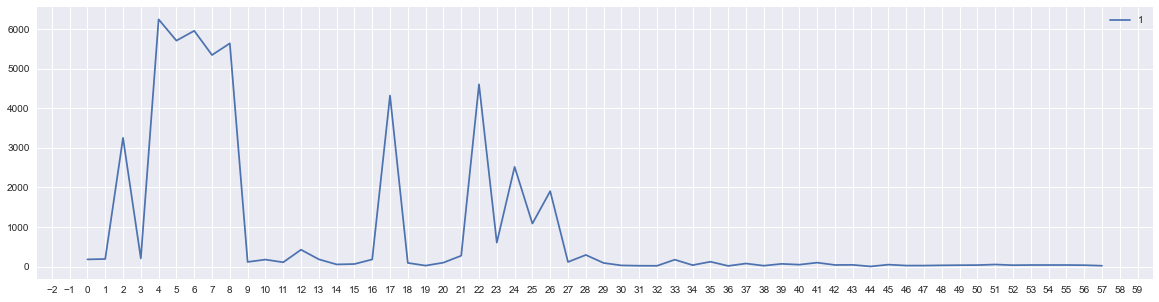

In [10]:
df_num = []
df_name = []
for col in products.columns:
    df_num.append(int(products[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator()) #Set a tick on each integer multiple of a base within the view interval.
plta.gcf().set_size_inches(20, 5)
plta.show() # to check which features can be given up
#it seems that starting from feature number 27, we can give up on all of the features
#it makes sense because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

we can see from the graph that the mass of products we have with more than 1000 non-zero values is between columns 2 to 26. Based on that, we created a new data set of only these features and the price columns. (the reason we decided not to take specific columns is to prevent doing overfitting)

In the end, when we tried to run the models we decided what kind of filtering is the most worthy, and which features are better for predictions (what feature selection we should do).

In [11]:
products2 = products.iloc[:,2:26] #we created the second dataset we wanted. We put it aside for a while.
prices2 = prices.copy()

## 3.Analyzing and visualizing the first data set:

### Uniting the desired columns:

In [12]:
def merge_two_columns(col1, col2, dataframe, index_col):
    if col1 in dataframe.columns and col2 in dataframe.columns: #checks if both columns exist in the data frame
        dataframe = dataframe.reset_index()
        row = 0
        for prod in dataframe[col1]: #running on the values in the column
            if (prod==0):
                if (dataframe.at[row , col2]!=0): 
                    dataframe.at[row, col1] =  dataframe.at[row ,col2]  
            row = row+1
        dataframe = dataframe.drop([col2], axis = 1)
        dataframe = dataframe.set_index(index_col, drop=True)
        return dataframe
    else:
        return dataframe

In [13]:
#we united the columns we set as a goal to unite in the beginning
products = merge_two_columns('A_vitamin', 'Vitamin_A_is_worth_retinol', products, 'Product_Name')
products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products, 'Product_Name')
products = merge_two_columns('potassium', 'K_Potassium', products, 'Product_Name')
products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', products, 'Product_Name')
products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Niacin', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Nicotinamide', products, 'Product_Name')

### Checking the correlations:

###### Checking the correlation between the Vitamin b's group:
we found on wikirefua that Folic acid = Vitamin B9, Niacin = Vitamin B3, Biotin = Vitamin B7 https://www.wikirefua.org.il/w/index.php?title=%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_B
It's written as well, that once, all the 8 types of Vitamin B(1, 2, 3, 5, 6, 7, 9, 12) were considered as the same vitamin - vitamin B.

In time, humanity found that they are different and each one has other functions. the reason why they all were considered the same Vitamin is that they are often appear together in the same types of food. 

Hence, we'll try to find a correlation between the different types of vitamin B, to unite them all under one column - the Vitamin B group.

<AxesSubplot:>

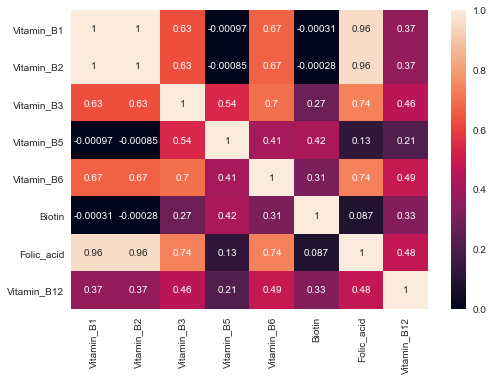

In [14]:
Bs = ['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B5', 'Vitamin_B6',  'Biotin', 'Folic_acid', 'Vitamin_B12']
vitamin_B = products.loc[:,Bs]
corrV = vitamin_B.corr()
sns.heatmap(corrV, annot=True)

From the matrix, we concluded that the column we might want to take to represent the Vitamin B group is either Vitamin_B1, Vitamin_B3, Vitamin_B6, or Vitamin_B9 (Folic_acid). 

We chose them by the number of correlations that are about>=0.8 (we didn't consider Vitamin_B2 because as we can see, the correlation between Vitamin_B1 and Vitamin_B2 is 1).

Now, we'll choose which one of the columns it will be by these criteria:
- the one with the higher correlations
- the one with the least lower correlations
- the one with the biggest correlation with the column we want to predict - price_per_100g

In [15]:
might_be_rep = ['Vitamin_B1', 'Vitamin_B6', 'Folic_acid', 'Vitamin_B3']
for rep in might_be_rep:
    column_1 = prices
    column_2 = products[rep]
    correlation = column_1.corr(column_2)
    print(rep, ": number of correlations that are greater than 0.8: ", (corrV[rep].sort_values(ascending=False)>0.8).sum())
    print(rep, ": number of correlations that are below or equal 0.2: ", (corrV[rep].sort_values(ascending=False)<=0.2).sum())
    print("correlation between price_per_100g and ",rep,": ", correlation)

Vitamin_B1 : number of correlations that are greater than 0.8:  3
Vitamin_B1 : number of correlations that are below or equal 0.2:  2
correlation between price_per_100g and  Vitamin_B1 :  0.012531075817514404
Vitamin_B6 : number of correlations that are greater than 0.8:  1
Vitamin_B6 : number of correlations that are below or equal 0.2:  0
correlation between price_per_100g and  Vitamin_B6 :  0.01890118527237466
Folic_acid : number of correlations that are greater than 0.8:  3
Folic_acid : number of correlations that are below or equal 0.2:  2
correlation between price_per_100g and  Folic_acid :  0.015009713781120017
Vitamin_B3 : number of correlations that are greater than 0.8:  1
Vitamin_B3 : number of correlations that are below or equal 0.2:  0
correlation between price_per_100g and  Vitamin_B3 :  0.015422283447490947


By the two first criteria we have put first, it seems that the columns we should take as a representative for the Vitamin B group are the column of Vitamin_B6 - it has the biggest number of correlations that are greater than 0.8 (which is 4), and it has the smallest number of correlations that are below or equal 0.2 (which is 1). It has, as well, the biggest correlation with price_per_100g.

we tried as well a different approach - instead of choosing one column to be the representative of the vitamin B group, we tried to merge between the different Vitamin Bs. we gave more significance to Vitamin_B6 and the ones that were designated to be the representatives by this order: first Vitamin_B6, then Vitamin_B9 (Folic_acid) (who has the best correlation with the price per 100g, and the smallest number of correlations that are below or equal 0.2 as well), After Vitamin_B1, and then Vitamin_B3, the last of the might_be_rep. Then there was be Vitamin_B12, which has the same number of greater than 0.8 correlations as Vitamin_B5, but fewer correlations that are below or equal to 0.2. And last but not least were Vitamin_B5 and Biotin, because we can see from the graph that Vitamin_B5 has the best higher correlationsand the Biotin the seconds.

we tried different combinations of the code that appears in the next window, but it seemed that no matter what we did, the correlation between the column we tried to create to the price_per_100g stayed the same.

In the end, we decided to stick with the Vitamin_B6 as the representer of this group, except for Vitamin_B5 and Biotin who had lower correlations with the rest of the Vitamin Bs' group, so we wanted to look further into them.

In [16]:
products['Partof_vitaminB'] = products['Vitamin_B6']
products = products.drop(['Vitamin_B6','Vitamin_B1','Vitamin_B2','Vitamin_B12','Folic_acid','Vitamin_B3'], axis=1)

In [17]:
corr_matrix5 = products.corr()
corr_matrix5['Vitamin_B5'].sort_values(ascending=False).head(10)
#the only connection found - between copper and b5: the need for vitamin B5 is reduced in a copper-deficient(https://www.traceelements.com/Docs/The%20Nutritional%20Relationships%20of%20Copper.pdf)

Vitamin_B5              1.000000
Biotin                  0.418366
Partof_vitaminB         0.410156
Vitamin_E.              0.314521
Inositol                0.276577
Alpha_linolenic_acid    0.275300
Choline                 0.268676
copper                  0.259866
iodine                  0.219451
Vitamin_K.              0.219172
Name: Vitamin_B5, dtype: float64

In [18]:
corr_matrix7 = products.corr()
corr_matrix7['Biotin'].sort_values(ascending=False).head(10)
#The only connection found - between biotin and vitamin e is: both told to help with looks of skin and hair(https://www.everydayhealth.com/pictures/supplements-skin-hair/) 

Biotin                  1.000000
Vitamin_B5              0.418366
Vitamin_E.              0.396381
Partof_vitaminB         0.311278
Vitamin_C               0.256539
Alpha_linolenic_acid    0.201720
Choline                 0.199558
Inositol                0.199430
Ascorbic_acid           0.197212
copper                  0.192290
Name: Biotin, dtype: float64

As we saw, the highest correlation Vitamin_B5 has is with Biotin, and Biotin's highest correlation is with Vitamin E. We couldn't find a reason for that connection between them, except for the fact that They are water-soluble, which means that the body can't store them. (https://medlineplus.gov/ency/article/002410.htm)

Furthermore, because we did find a representative of the majority of the Vitamin B group, we decided we wanted to look for a correlation within all the vitamin groups.

<AxesSubplot:>

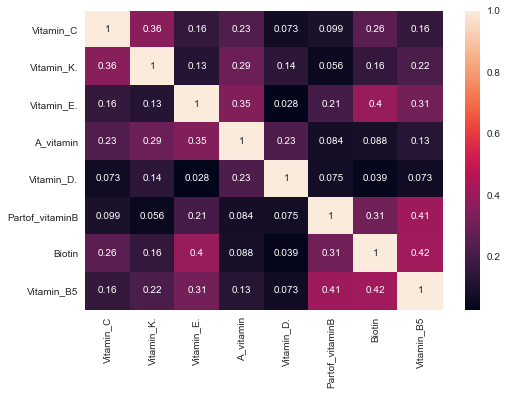

In [19]:
vitamins_lst=['Vitamin_C','Vitamin_K.','Vitamin_E.','A_vitamin','Vitamin_D.' ,'Partof_vitaminB', 'Biotin', 'Vitamin_B5']
vitaminS = products.loc[:,vitamins_lst]
corrvl = vitaminS.corr()
sns.heatmap(corrvl, annot=True)

There isn't a particularly high correlation. There is a weak connection between a couple of them, but we can attribute that to the fact that a lot of the times vitamin appears together in the same kinds of foods (such as fruits).

###### Checking correlations between all the things that contain sugars (and Carbohydrate_sugars and Carbohydrate):

<AxesSubplot:>

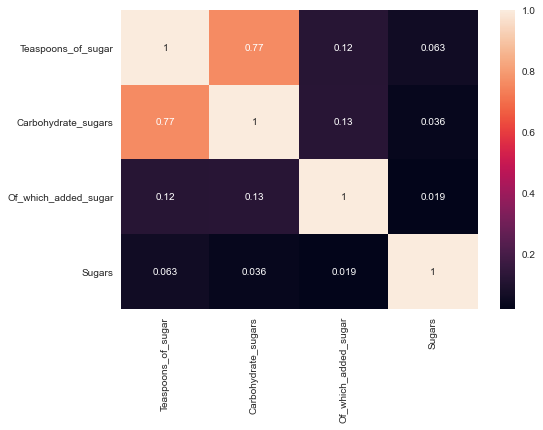

In [20]:
corr_matrix = products.corr()
Sm = ['Teaspoons_of_sugar', 'Carbohydrate_sugars', 'Of_which_added_sugar', 'Sugars']
Sugars_matix = products.loc[:,Sm]
corrS = Sugars_matix.corr()
sns.heatmap(corrS,annot=True)

From the graph, we saw that the only strong correlation there is between Teaspoons_of_sugar and Carbohydrate_sugars, which is about 0.8.

The correlation between "Teaspoons of sugar" and "Carbohydrate sugars" is high, because as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that Teaspoons of sugar = Carbohydrate sugars/4. 

Then, we checked the correlation between Teaspoons_of_sugar, Carbohydrate_sugars, and price_per_100g (to decide on which of the two columns we should give up), but before the decision to drop the Carbohydrate sugars column, we checked as well the correlation between Carbohydrates and Carbohydrate_sugars, as we wanted before.

In [21]:
column_1 = products["Carbohydrate_sugars"]
column_2 = products["Carbohydrates"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrates and Carbohydrate_sugars ", correlation)

correlation between Carbohydrates and Carbohydrate_sugars  0.4499130505845524


The correlation between Carbohydrates and Carbohydrate_sugars is lower than the one between Carbohydrate_sugars and Teaspoons_of_sugar (where there is an exact formula to calculate the connection). 

Due to that, we decided to drop the Carbohydrate sugars column.

In [22]:
products = merge_two_columns('Carbohydrate_sugars', 'Teaspoons_of_sugar', products, 'Product_Name')

###### Checking correlations between energy and the rest of the nutrition values:

In [23]:
corr_matrix = products.corr()
corr_matrix["energy"].sort_values(ascending=False)
print(corr_matrix["energy"].sort_values(ascending=False).head(10))

energy                    1.000000
Fats                      0.754608
Carbohydrates             0.433070
Carbohydrate_sugars       0.356064
Dietary_fiber             0.216757
iron                      0.144447
Proteins                  0.120627
Cholesterol               0.096282
Of_which_saturated_fat    0.086083
Trans_fatty_acids         0.084366
Name: energy, dtype: float64


The strong correlation between "energy" and "Fats" is high, because as we found at Wikipedia, https://he.wikipedia.org/wiki/%D7%A7%D7%9C%D7%95%D7%A8%D7%99%D7%94, energy, which is Calories can be calculated by: 1g of Fats=1g of energy*9 .

In [24]:
column_1 = products["energy"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with energy ", correlation)
column_1 = products["Fats"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with Fats ", correlation)

correlation with energy  0.027415116148852624
correlation with Fats  0.07408246669143856


The correlation between Fats and the price is higher than The correlation between energy and the price. Thus, we decided to merge the energy column into the Fats column.

In [25]:
products = merge_two_columns('Fats', 'energy', products, 'Product_Name')

###### Checking correlations between the many kinds of fat: 
(we'll just point out that Linoleic_fatty_acid and Alpha_Linolenic_Acid are not the same fatty acid. In their compound, Linoleic_fatty_acid has 2 more hydrogens than Alpha_Linolenic_Acid)

Alpha_Linolenic_Acid(ALA)'s compound: C18H30O2 (https://en.wikipedia.org/wiki/Alpha-Linolenic_acid)

Linoleic_fatty_acid's compound: C18H32O2 (https://en.wikipedia.org/wiki/Linoleic_acid)

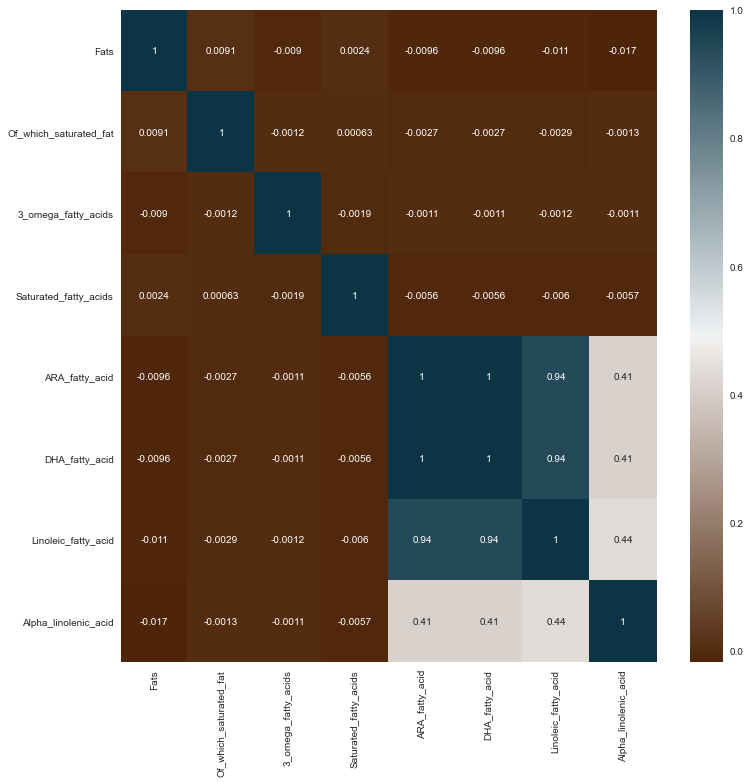

In [26]:
Ft = ['Fats','Of_which_saturated_fat','3_omega_fatty_acids','Saturated_fatty_acids'
             ,'ARA_fatty_acid', 'DHA_fatty_acid','Linoleic_fatty_acid','Alpha_linolenic_acid']
Fats_list = products.loc[:,Ft]
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(Fats_list.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)

we can see from the graph that there is an area with a high correlation between three features - ARA_fatty_acid, DHA_fatty_acid, and Linoleic_fatty_acid. The higher correlations are with ARA_fatty_acid so we decided to dig further into the origins of ARA_fatty_acid. 

we found out that Linoleic acid, ARA_fatty_acid are subsets of 6_omega_fatty_acids https://en.wikipedia.org/wiki/Omega-6_fatty_acid

We decided to unite these columns, but not before we checked does some of the fats we have are subsets of 3_omega_fatty_acids. we discovered that DHA_fatty_acid together with ALA (which is Alpha_Linolenic_Acid) are subsets of 3_omega_fatty_acids.https://en.wikipedia.org/wiki/Omega-3_fatty_acid

Also, we found that there is a connection between linoleic acids and oleic acids.

In [27]:
products['6_omega_fatty_acids'] = products['ARA_fatty_acid']
products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', products, 'Product_Name')

After that, we wanted to check the correlation matrix of all the features that have been left, to see if there's anything else worth checking(a.k.a merging or dropping).

<AxesSubplot:>

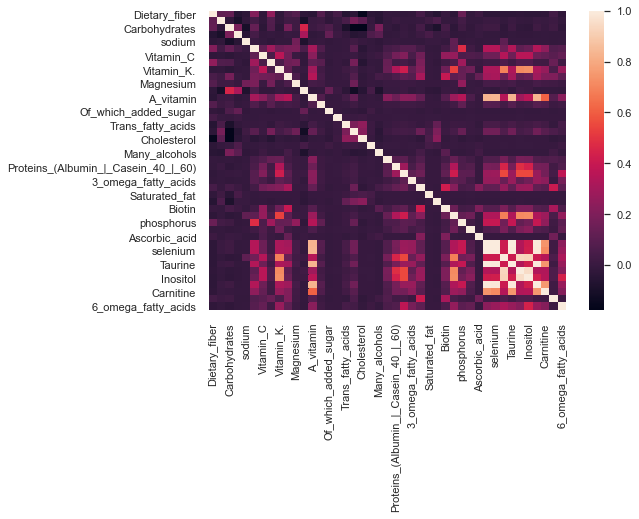

In [28]:
corr_matrix = products.corr()
sns.heatmap(corr_matrix) 

We noticed that Nucleotides has a couple of high correlations, so we decided to check that out.

In [29]:
print(corr_matrix["Nucleotides"].sort_values(ascending=False).head(15))

Nucleotides                       1.000000
Taurine                           0.997463
selenium                          0.995566
chlorine                          0.994288
A_vitamin                         0.833794
Carnitine                         0.739932
Inositol                          0.419211
copper                            0.414246
phosphorus                        0.394302
potassium                         0.343315
Choline                           0.342100
iodine                            0.331098
Vitamin_K.                        0.323811
Vitamin_E.                        0.301256
From_the_carbohydrates_lactose    0.277454
Name: Nucleotides, dtype: float64


We found that the high correlation between Nucleotides, Choline, and Taurine can be explained by the fact that they are all are very popular in baby food (https://www.cfs.gov.hk/english/multimedia/multimedia_pub/multimedia_pub_fsf_81_02.html), so we decided to merge these three nutrition values into one column.

other than that we weren't able to find any more explanations for the high correlations, but we did find interesting connections between a couple of the nutrition values, attached for your reference:

(found a connection between taurine on the toxicity of vitamin A in rats: https://www.sciencedirect.com/science/article/abs/pii/S0308814607005420

found a comparison between chronic taurine and vitamin E plus selenium supplementations: https://pubmed.ncbi.nlm.nih.gov/12688428/

found rate studies of the destruction of polyunsaturated fatty acids in vitro by chlorine-based disinfectants: https://pubmed.ncbi.nlm.nih.gov/1504266/

we have consulted with a chimist but the only big connection was between the molecular structure of Vitamin_A and 6_omega_fatty_acids and the fact that they are both dissolved in fat / both fatty).

In [30]:
products['have_to_do_with_milk'] = products['Nucleotides'] 
products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', products, 'Product_Name')
products = merge_two_columns('have_to_do_with_milk', 'Choline', products, 'Product_Name')
products = merge_two_columns('have_to_do_with_milk', 'Taurine', products, 'Product_Name')

For the last cleaning, before going into testing models, we wanted to search if there are columns we can merge in the second data set that we have already merged in the first one.

In [31]:
products2.columns

Index(['Dietary_fiber', 'Folic_acid', 'energy', 'Proteins', 'Carbohydrates',
       'Fats', 'sodium', 'Vitamin_B3', 'potassium', 'Vitamin_C', 'iron',
       'Vitamin_B2', 'Vitamin_K.', 'Vitamin_E.', 'Magnesium',
       'Carbohydrate_sugars', 'A_vitamin', 'Dietary_fiber.1', 'zinc',
       'Of_which_added_sugar', 'Of_which_saturated_fat', 'Trans_fatty_acids',
       'Teaspoons_of_sugar', 'calcium'],
      dtype='object')

There was indeed a few merges we have already done in the first data set, so we did them as well on the second.

In [32]:
products2 = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products2, 'Product_Name')
products2 = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', products2, 'Product_Name')
products2 = merge_two_columns('Fats', 'energy', products2, 'Product_Name')

## 4. Choosing a metric method and checking habits of dummy-model: 

After we accomplished all of our goals from the beginning and by that prepared the data, we wanted to choose a performance measure. for a regression project, like ours there are a few performance measures.


we decided to measure our project by RMSE.

RMSE means- is the square root of the mean of the square of all of the errors.

we decided to choose RMSE because it is considered an excellent general-purpose error metric for numerical predictions.

what we did next was to create a function that is functioning as a pipeline (doing a series of orders by order), to prepare new data coming.
Then we checked the dummy regressor score.

In [33]:
def data_ready_version_1(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('code')
    dataw = dataw.drop_duplicates()
    dataw = dataw.set_index('Product_Name')
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_products = dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    dataw_products = merge_two_columns('A_vitamin', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Nicotinamide', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Folic_acid','Vitamin_B1','Vitamin_B12','Vitamin_B3'], axis=1)
    dataw_products = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Fats', 'energy', dataw_products, 'Product_Name')
    dataw_products['6_omega_fatty_acids'] = dataw_products['ARA_fatty_acid']
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    dataw_products['have_to_do_with_milk'] = dataw_products['Nucleotides'] 
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Choline', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Taurine', dataw_products, 'Product_Name')
    
    return dataw_products, dataw_prices

In [34]:
def data_ready_version_2(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('code')
    dataw = dataw.drop_duplicates()
    dataw = dataw.set_index('Product_Name')
    
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    
    
    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    
    dataw_products = dataw.drop("price_per_100g", axis=1).iloc[:,2:26] 
    dataw_prices = dataw["price_per_100g"].copy()
    
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Fats', 'energy', dataw_products, 'Product_Name')
    
    return dataw_products, dataw_prices

In [35]:
def RMSE(real, prediction):
    return np.sqrt(MSE(real, prediction))

In [36]:
test_set_prod1, test_set_prices1 = data_ready_version_1(test_set)

In [37]:
test_set_prod2, test_set_prices2 = data_ready_version_2(test_set)

In [38]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum1 = dummy_regr.predict(test_set_prod1)
mser = RMSE(test_set_prices1, predictdum1)
print( "Dummy Regressor mean squared error of " + str(mser)[:4])

Dummy Regressor mean squared error of 6.62


In [39]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products2, prices2)
predictdum2 = dummy_regr.predict(test_set_prod2)
mser = RMSE(test_set_prices2, predictdum2)
print( "Dummy Regressor mean squared error of " + str(mser)[:4])

Dummy Regressor mean squared error of 6.62


## 5. Sampling models (and checking with cross validation):

For each model we tried to find every parameter's importance by Feature Importance and by tried to fine-tune our models: (source - https://machinelearningmastery.com/calculate-feature-importance-with-python/)

## A. Linear regression

Linear regression is a model that tries to find a linear connection between all the features that has been given to it.

In [40]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

lin_reg = LinearRegression()
predict1 = cross_val_predict(lin_reg, products, prices, cv=kf)
rmse_linreg1 = RMSE(prices, predict1)
print(rmse_linreg1)

predict2 = cross_val_predict(lin_reg, products2, prices2, cv=kf)
rmse_linreg2 = RMSE(prices2, predict2)
print(rmse_linreg2)

10.441611894477829
310.0917302263486


we noticed that the score of the second version of the data set in the linear regression does not make sense. We looked through the values that the model gives to each product and found an outlier. After removing it, another outlier popped up. We couldn't explain the appearance of the outliers except for the fact that linear regression is not suitable for the task (even for the first data set, its score is worse than the dummy model's score).

Feature: 0, Score: 0.07259
Feature: 1, Score: 0.00044
Feature: 2, Score: -0.03431
Feature: 3, Score: -0.00043
Feature: 4, Score: 0.00007
Feature: 5, Score: -0.00362
Feature: 6, Score: -0.05660
Feature: 7, Score: -0.06485
Feature: 8, Score: -0.13292
Feature: 9, Score: 0.55664
Feature: 10, Score: 0.00036
Feature: 11, Score: 0.05484
Feature: 12, Score: -0.00147
Feature: 13, Score: -0.01274
Feature: 14, Score: -0.06679
Feature: 15, Score: 0.00049
Feature: 16, Score: 0.08635
Feature: 17, Score: 0.00042
Feature: 18, Score: 0.00748
Feature: 19, Score: -0.11737
Feature: 20, Score: 0.14963
Feature: 21, Score: -0.04916
Feature: 22, Score: -0.04974
Feature: 23, Score: 0.07271
Feature: 24, Score: 0.00098
Feature: 25, Score: 0.28987
Feature: 26, Score: 0.06170
Feature: 27, Score: -0.01540
Feature: 28, Score: -0.14615
Feature: 29, Score: -0.01089
Feature: 30, Score: -0.00026
Feature: 31, Score: -0.01071
Feature: 32, Score: -0.00531
Feature: 33, Score: -0.27276
Feature: 34, Score: -0.05831
Feature: 3

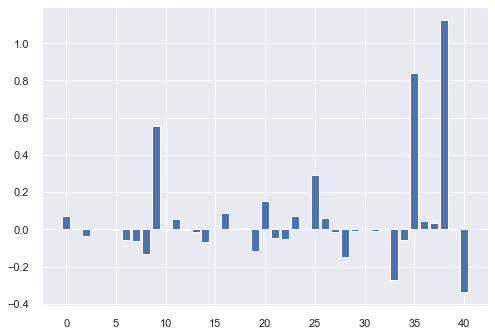

Feature: 9, Score: 0.55664
Feature: 35, Score: 0.84152
Feature: 38, Score: 1.12218
Feature: 40, Score: -0.33778


In [41]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products, prices)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm =[]
for i,v in enumerate(importance):
    if abs(v)>0.3:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [42]:
productsv = products.iloc[:,listm]
predict = cross_val_predict(lin_reg, productsv, prices, cv=kf)
rmse_linreg1_v2 = RMSE(prices, predict)
print(rmse_linreg1_v2)

10.47714983197796


Feature: 0, Score: 0.04076
Feature: 1, Score: 0.01286
Feature: 2, Score: -0.00421
Feature: 3, Score: -0.01322
Feature: 4, Score: 0.00242
Feature: 5, Score: 0.00003
Feature: 6, Score: -0.29116
Feature: 7, Score: -0.00383
Feature: 8, Score: -0.05389
Feature: 9, Score: -0.09828
Feature: 10, Score: -0.00518
Feature: 11, Score: 0.01906
Feature: 12, Score: 0.23331
Feature: 13, Score: 0.00021
Feature: 14, Score: 0.00438
Feature: 15, Score: -0.01437
Feature: 16, Score: -0.06855
Feature: 17, Score: 0.00061
Feature: 18, Score: 0.17162
Feature: 19, Score: 0.02171
Feature: 20, Score: 0.00098


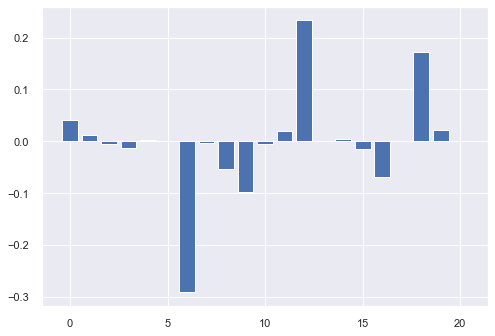

Feature: 0, Score: 0.04076
Feature: 1, Score: 0.01286
Feature: 3, Score: -0.01322
Feature: 6, Score: -0.29116
Feature: 8, Score: -0.05389
Feature: 9, Score: -0.09828
Feature: 10, Score: -0.00518
Feature: 11, Score: 0.01906
Feature: 12, Score: 0.23331
Feature: 15, Score: -0.01437
Feature: 16, Score: -0.06855
Feature: 18, Score: 0.17162
Feature: 19, Score: 0.02171


In [43]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products2, prices2)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm2 =[]
for i,v in enumerate(importance):
    if abs(v)>0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [44]:
productsv2 = products.iloc[:,listm]
predict2 = cross_val_predict(lin_reg, productsv2, prices2, cv=kf)
rmse_linreg2_v2 = RMSE(prices, predict2)
print(rmse_linreg2_v2)

10.48037411251415


Although feature selection did help with improving the scores of both models, their scores were still not good, so we tried other models.

## B. Decision tree regressor

Decision tree regressor is a model that creates a binary tree based on a threshold and a feature that creates an optimal tree.

In [45]:
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products, prices, cv=kf)
treereg_score1 = RMSE(prices, predicttree1)
print(treereg_score1)

predicttree2 = cross_val_predict(tree_reg, products2, prices2, cv=kf)
treereg_score2 = RMSE(prices2, predicttree2)
print(treereg_score2)

11.90370634033807
7.352132395613852


Feature: 0, Score: 0.02193
Feature: 1, Score: 0.03569
Feature: 2, Score: 0.03481
Feature: 3, Score: 0.11151
Feature: 4, Score: 0.43753
Feature: 5, Score: 0.00007
Feature: 6, Score: 0.00001
Feature: 7, Score: 0.00187
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00287
Feature: 10, Score: 0.00039
Feature: 11, Score: 0.02828
Feature: 12, Score: 0.00012
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00181
Feature: 15, Score: 0.27668
Feature: 16, Score: 0.00176
Feature: 17, Score: 0.00477
Feature: 18, Score: 0.00716
Feature: 19, Score: 0.00042
Feature: 20, Score: 0.02242
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00006
Feature: 23, Score: 0.00016
Feature: 24, Score: 0.00001
Feature: 25, Score: 0.00035
Feature: 26, Score: 0.00017
Feature: 27, Score: 0.00026
Feature: 28, Score: 0.00003
Feature: 29, Score: 0.00027
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00020
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00066
Feature: 35, Score: 0.00000
Fe

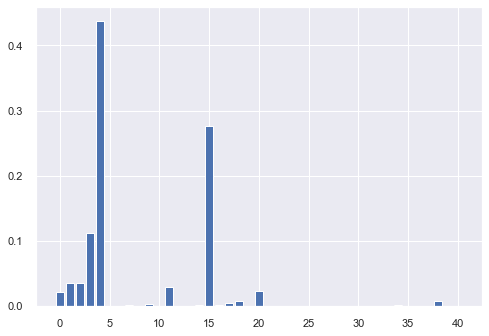

Feature: 0, Score: 0.02193
Feature: 1, Score: 0.03569
Feature: 2, Score: 0.03481
Feature: 3, Score: 0.11151
Feature: 4, Score: 0.43753
Feature: 11, Score: 0.02828
Feature: 15, Score: 0.27668
Feature: 18, Score: 0.00716
Feature: 20, Score: 0.02242
Feature: 38, Score: 0.00763


In [46]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products, prices)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi = []
for i,v in enumerate(importance):
    if v>0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi.append(i)

In [47]:
products_3 = products.iloc[:,listi]
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products_3, prices, cv=kf)
treereg_score1_v2 = RMSE(prices, predicttree1)
print(treereg_score1_v2)

7.552595259300384


Feature: 0, Score: 0.02758
Feature: 1, Score: 0.00272
Feature: 2, Score: 0.03448
Feature: 3, Score: 0.03581
Feature: 4, Score: 0.08961
Feature: 5, Score: 0.44748
Feature: 6, Score: 0.00014
Feature: 7, Score: 0.00005
Feature: 8, Score: 0.00140
Feature: 9, Score: 0.00218
Feature: 10, Score: 0.00621
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00033
Feature: 13, Score: 0.00002
Feature: 14, Score: 0.00085
Feature: 15, Score: 0.00015
Feature: 16, Score: 0.00094
Feature: 17, Score: 0.03895
Feature: 18, Score: 0.00200
Feature: 19, Score: 0.30452
Feature: 20, Score: 0.00457


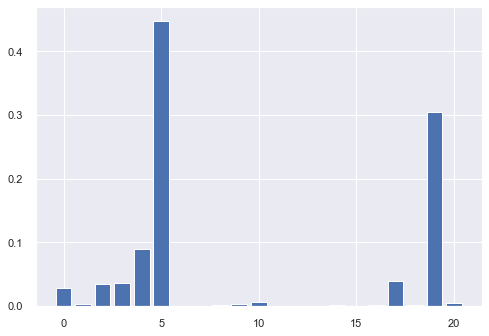

Feature: 4, Score: 0.08961
Feature: 5, Score: 0.44748
Feature: 19, Score: 0.30452


In [48]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products2, prices2)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi2 = []
for i,v in enumerate(importance):
    if v>0.05:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi2.append(i)

In [49]:
products2_3 = products.iloc[:,listi2]
tree_reg = DecisionTreeRegressor()

predicttree2 = cross_val_predict(tree_reg, products2_3, prices2, cv=kf)
treereg_score2_v2 = RMSE(prices2, predicttree2)
print(treereg_score2_v2)

8.862371481453774


On this model, the scores were a bit better, but we wanted to try and make the model even better!

## C. Random forest regressor

Random forest regressor is a model that creates a couple of binary trees, trying with the data set that has been given a random few of them and chooses the one that performed best.

In [50]:
random_for = RandomForestRegressor()

prodicrfor1 = cross_val_predict(random_for, products, prices, cv=kf)
rmsefor1 = RMSE(prices, prodicrfor1)
print(rmsefor1)

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2, prices2, cv=kf)
rmsefor2 = RMSE(prices, prodicrfor2)
print(rmsefor2)

7.634510027467888
7.530299935692334


Feature: 0, Score: 0.06213
Feature: 1, Score: 0.06177
Feature: 2, Score: 0.07056
Feature: 3, Score: 0.13572
Feature: 4, Score: 0.44537
Feature: 5, Score: 0.00032
Feature: 6, Score: 0.00038
Feature: 7, Score: 0.00330
Feature: 8, Score: 0.00006
Feature: 9, Score: 0.00448
Feature: 10, Score: 0.00053
Feature: 11, Score: 0.08715
Feature: 12, Score: 0.00036
Feature: 13, Score: 0.00031
Feature: 14, Score: 0.00135
Feature: 15, Score: 0.07321
Feature: 16, Score: 0.00205
Feature: 17, Score: 0.00489
Feature: 18, Score: 0.00984
Feature: 19, Score: 0.00025
Feature: 20, Score: 0.03019
Feature: 21, Score: 0.00005
Feature: 22, Score: 0.00002
Feature: 23, Score: 0.00017
Feature: 24, Score: 0.00009
Feature: 25, Score: 0.00018
Feature: 26, Score: 0.00008
Feature: 27, Score: 0.00028
Feature: 28, Score: 0.00016
Feature: 29, Score: 0.00023
Feature: 30, Score: 0.00016
Feature: 31, Score: 0.00003
Feature: 32, Score: 0.00299
Feature: 33, Score: 0.00001
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00002
Fe

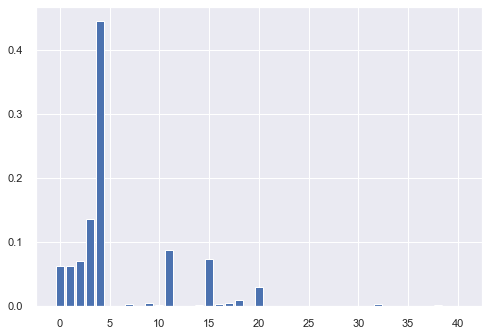

Feature: 0, Score: 0.06213
Feature: 1, Score: 0.06177
Feature: 2, Score: 0.07056
Feature: 3, Score: 0.13572
Feature: 4, Score: 0.44537
Feature: 11, Score: 0.08715
Feature: 15, Score: 0.07321
Feature: 18, Score: 0.00984
Feature: 20, Score: 0.03019


In [51]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products, prices)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listo = []
for i,v in enumerate(importance):
    if v>0.009:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listo.append(i)

In [52]:
products_2 = products.iloc[:,listo]

random_for = RandomForestRegressor()
prodicrfor = cross_val_predict(random_for, products_2, prices, cv=kf)
rmsefor1_v2 = RMSE(prices, prodicrfor)
print(rmsefor1_v2)

7.652079468417092


Feature: 0, Score: 0.05660
Feature: 1, Score: 0.00320
Feature: 2, Score: 0.09550
Feature: 3, Score: 0.06510
Feature: 4, Score: 0.14526
Feature: 5, Score: 0.43119
Feature: 6, Score: 0.00020
Feature: 7, Score: 0.00028
Feature: 8, Score: 0.00052
Feature: 9, Score: 0.00275
Feature: 10, Score: 0.00521
Feature: 11, Score: 0.00006
Feature: 12, Score: 0.00041
Feature: 13, Score: 0.00073
Feature: 14, Score: 0.00022
Feature: 15, Score: 0.00024
Feature: 16, Score: 0.00130
Feature: 17, Score: 0.08641
Feature: 18, Score: 0.00300
Feature: 19, Score: 0.09767
Feature: 20, Score: 0.00415


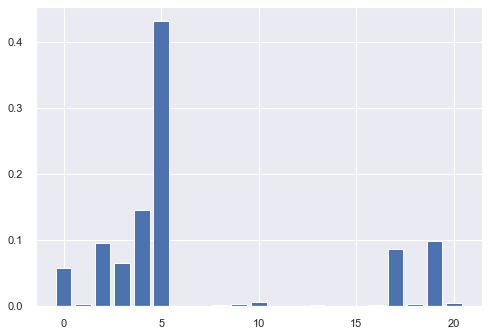

Feature: 0, Score: 0.05660
Feature: 2, Score: 0.09550
Feature: 3, Score: 0.06510
Feature: 4, Score: 0.14526
Feature: 5, Score: 0.43119
Feature: 10, Score: 0.00521
Feature: 17, Score: 0.08641
Feature: 19, Score: 0.09767


In [53]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products2, prices2)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listo2 = []
for i,v in enumerate(importance):
    if v>0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listo2.append(i)

In [54]:
products2_2 = products.iloc[:,listo2]

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2_2, prices2, cv=kf)
rmsefor2_v2 = RMSE(prices2, prodicrfor2)
print(rmsefor2_v2)

7.5117091294461265


## 6. Comparing models scores and choosing the final model:

In [55]:
print("Before Feature Importance, Linear regression mean squared error is:")
print()
print("Data set 1: ", rmse_linreg1, ", Data set 2: ", rmse_linreg2)
print('\n')
print("After Feature Importance, Linear regression mean squared error is:")
print()
print("Data set 1: ", rmse_linreg1_v2, ", Data set 2: ", rmse_linreg2_v2)

Before Feature Importance, Linear regression mean squared error is:

Data set 1:  10.441611894477829 , Data set 2:  310.0917302263486


After Feature Importance, Linear regression mean squared error is:

Data set 1:  10.47714983197796 , Data set 2:  10.48037411251415


In [56]:
print("Before Feature Importance, Decision tree regressor mean squared error is:")
print()
print("Data set 1: ", treereg_score1, ", Data set 2: ", treereg_score2)
print('\n')
print("After Feature Importance, Decision tree regressor mean squared error is:")
print()
print("Data set 1: ", treereg_score1_v2, ", Data set 2: ", treereg_score2_v2)

Before Feature Importance, Decision tree regressor mean squared error is:

Data set 1:  11.90370634033807 , Data set 2:  7.352132395613852


After Feature Importance, Decision tree regressor mean squared error is:

Data set 1:  7.552595259300384 , Data set 2:  8.862371481453774


In [57]:
print("Before Feature Importance, Random forest regressor mean squared error is:")
print()
print("Data set 1: ", rmsefor1, ", Data set 2: ", rmsefor2)
print('\n')
print("After Feature Importance, Random forest regressor mean squared error is:")
print()
print("Data set 1: ", rmsefor1_v2, ", Data set 2: ", rmsefor2_v2)

Before Feature Importance, Random forest regressor mean squared error is:

Data set 1:  7.634510027467888 , Data set 2:  7.530299935692334


After Feature Importance, Random forest regressor mean squared error is:

Data set 1:  7.652079468417092 , Data set 2:  7.5117091294461265


In [58]:
print("Dummy regressor mean squared error is:", str(mser)[:4])

Dummy regressor mean squared error is: 6.62


From the comparison above we can conclude that our best model is Random Forest regressor with the second version of data set number 1 (each time we ran the project, the difference between the mistakes of version 1 and 2 of the first data set were close to each other, although every time another one of them was with a bigger mistake, due to the nature of the model).
Because the errors are close to each other, we will prefer the version of the model with fewer features.

In [59]:
def final_data_preperation(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('code')
    dataw = dataw.drop_duplicates()
    dataw = dataw.set_index('Product_Name')
    
    dataw = dataw.drop_duplicates()
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_products= dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    dataw_products = merge_two_columns('A_vitamin', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Nicotinamide', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Folic_acid','Vitamin_B1','Vitamin_B12','Vitamin_B3'], axis=1)
    dataw_products = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Fats', 'energy', dataw_products, 'Product_Name')
    dataw_products['6_omega_fatty_acids'] = dataw_products['ARA_fatty_acid']
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    dataw_products['have_to_do_with_milk'] = dataw_products['Nucleotides'] #found that Nucleotides, choline and taurine are all in babys' milk frmula
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Choline', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Taurine', dataw_products, 'Product_Name')
    
    listow = listo
    dataw_products = dataw_products.iloc[:,listow]
    
    return dataw_products, dataw_prices

In [60]:
final_test_prod, final_test_price = final_data_preperation(test_set)

In [61]:
random_for = RandomForestRegressor()
random_for.fit(products_2, prices)
final_predict = random_for.predict(final_test_prod)
Rmse = RMSE(final_test_price, final_predict)
print( "Mean squared error of final model is: " + str(Rmse)[:4])

Mean squared error of final model is: 5.03


## 7. conclusion:

The mean squared error of the final model is big, although it's still better than the dummy model.
Because of the fact that the mean squared error of the final model is better than the train's one, we suspected a data leakage, but couldn't find one.

Since we used the same cleaning method for a classification project on the same data and scored 71% accuracy, it seems that the problem is not with the data cleaning and manipulation that we did but with the models (that are not suitable for the task) or with the fact that there are other parameters other than nutrition values that affect products prices, such as seasonality and taxes.

Classification project on nutrition values and product's category: https://github.com/shira-chesler/Data_Science_intro_project/blob/062eeab86489171a67af7bf179bee068242822fe/Classification/classification_project.ipynb